
# EDA: Reuters_50_50 (Human-Generated) — Structural & Signal Properties

This notebook performs a **preliminary exploratory data analysis (EDA)** on the *human-only* **Reuters_50_50** subset (from UC Irvine), combining train/test to focus on broad structural, lexical, and **signal-style** properties (sentence-length dynamics, simple Fourier views, etc.).

**Goal:** establish a **baseline fingerprint** of human-generated newswire text **without** using any LLM scoring (no log-probs). This foundation will later help contrast against LLM-generated text.

**Dataset layout (expected):**
```
data/rcv1-uc-irvine-subset/reuter5050/
├── C50test/
│   ├── AaronPressman/
│   │   ├── *.txt
│   ├── AlanCrosby/
│   │   ├── *.txt
└── C50train/
    ├── AaronPressman/
    │   ├── *.txt
    ├── AlanCrosby/
        ├── *.txt
```



## 1) Corpus Overview

We verify counts, combine train/test (since we don't care about that distinction right now), and examine document length distributions:
- Documents per author
- Words / characters / sentences per document (mean/median/min/max)
- Histograms of document lengths


In [ ]:
# Imports for the notebook
import random
import re
import string
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

In [7]:
# -------- CONFIG --------
BASE_DIR = Path("data/rcv1-uc-irvine-subset/reuter5050")
SAVE_DIR: Path = Path("eda_outputs/reuters_5050")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
# Lightweight tokenization & sentence splitting (no external downloads)
WORD_RE: re.Pattern = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")
SENT_SPLIT_RE: re.Pattern = re.compile(r"[.!?]+(?:\s+|$)")

def simple_sent_tokenize(text: str) -> list[str]:
    # Split on ., !, ?, keep sentences non-empty, strip whitespace
    parts = SENT_SPLIT_RE.split(text)
    return [p.strip() for p in parts if p.strip()]

def simple_word_tokenize(text: str) -> list[str]:
    return WORD_RE.findall(text.lower())

def read_all_docs(base_dir: Path) -> pd.DataFrame:
    rows = []
    for split in ["C50train", "C50test"]:
        split_dir = base_dir / split
        if not split_dir.exists():
            continue
        for author_dir in sorted([p for p in split_dir.iterdir() if p.is_dir()]):
            author = author_dir.name
            for f in sorted(author_dir.glob("*.txt")):
                try:
                    txt = f.read_text(encoding="latin-1")  # Reuters files are often latin-1
                except UnicodeDecodeError:
                    txt = f.read_text(errors="ignore")
                rows.append({
                    "split": split,
                    "author": author,
                    "path": str(f),
                    "text": txt,
                })
    return pd.DataFrame(rows)

df: pd.DataFrame = read_all_docs(BASE_DIR)
print(f"Total docs: {len(df)}")
print("Authors:", df['author'].nunique())

# Compute basic lengths
def doc_stats(text: str) -> dict[str, int]:
    sents = simple_sent_tokenize(text)
    words = simple_word_tokenize(text)
    return {
        "n_chars": len(text),
        "n_sents": len(sents),
        "n_words": len(words),
    }

basic: pd.DataFrame = df["text"].apply(doc_stats).apply(pd.Series)
df: pd.DataFrame = pd.concat([df, basic], axis=1)

# Summary
corpus_summary: dict[str, float | int] = {
    "n_docs": int(len(df)),
    "n_authors": int(df["author"].nunique()),
    "words_total": int(df["n_words"].sum()),
    "words_mean": float(df["n_words"].mean()),
    "words_median": float(df["n_words"].median()),
    "sents_mean": float(df["n_sents"].mean()),
    "sents_median": float(df["n_sents"].median()),
}
pd.DataFrame([corpus_summary])



Total docs: 5000
Authors: 50


,n_docs,n_authors,words_total,words_mean,words_median,sents_mean,sents_median
0,5000,50,2495704,499.1408,504.0,22.4984,22.0


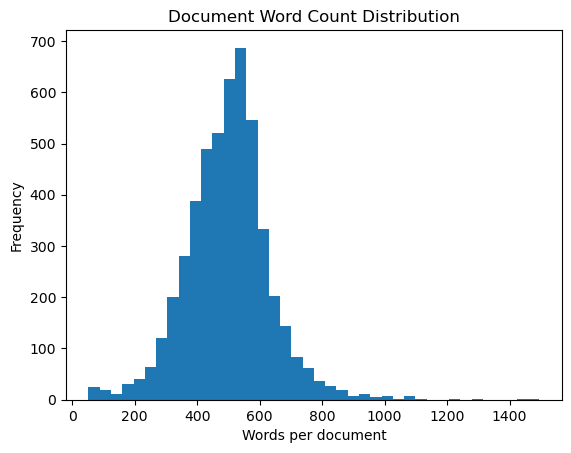

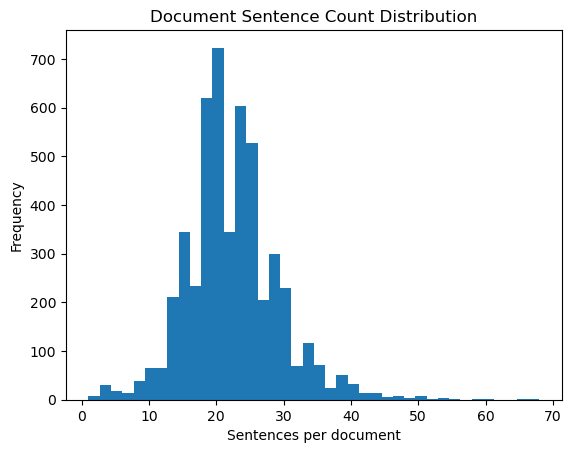

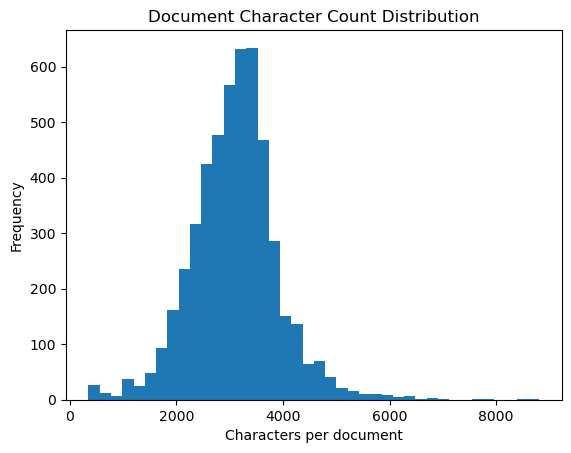

In [ ]:

# Histograms of document length properties
plt.figure()
plt.hist(df["n_words"], bins=40)
plt.title("Document Word Count Distribution")
plt.xlabel("Words per document"); plt.ylabel("Frequency")
plt.savefig(SAVE_DIR / "section1_word_count_distribution.png")
plt.show()

plt.figure()
plt.hist(df["n_sents"], bins=40)
plt.title("Document Sentence Count Distribution")
plt.xlabel("Sentences per document"); plt.ylabel("Frequency")
plt.savefig(SAVE_DIR / "section1_sent_count_distribution.png")
plt.show()

plt.figure()
plt.hist(df["n_chars"], bins=40)
plt.title("Document Character Count Distribution")
plt.xlabel("Characters per document"); plt.ylabel("Frequency")
plt.savefig(SAVE_DIR / "section1_char_count_distribution.png")
plt.show()

### Findings from Corpus Overview

The **Reuters_50_50 corpus** (combined train/test) contains **5,000 documents** authored by **50 distinct journalists** (100 documents each).  
Overall, the dataset has **2.5 million words**, with an average of **499 words per document** (median 504).  
Sentence counts average **22 per document** (median 22), which corresponds well with the observed word counts.

#### Document Lengths
- **Word counts:** Most documents cluster tightly between **350–650 words**, with a long right tail extending above 1,200 words. This matches the expected length of short newswire articles.  
- **Sentence counts:** The majority fall between **15–30 sentences**.  
- **Character counts:** The main bulk lies around **2,500–3,500 characters**, again showing strong central tendency with some longer outliers.

#### Distribution Shape
- All three distributions (characters, sentences, words) are approximately **bell-shaped but slightly right-skewed**, meaning there are relatively few long articles compared to the bulk of medium-length ones.
- Word and Character distributions look fairly smooth, while sentence distribution looks almost multimodal due to one large gap around 22 sentences, and a couple medium gaps on either side of that.   
- The **consistency in median and mean values** suggests the dataset is balanced and avoids extreme skew, making it a strong candidate for baseline modeling of human text.

#### Implications
- The **uniformity of document size** is useful for this LLM fingerprinting project as it provides a smooth-ish target for the LLM-generated text.  
- The **right-tail outliers** could be especially interesting — comparing whether LLMs generate unusually long or short articles relative to this human baseline.  
- I will try to infuse these characteristics into the prompts for LLM-generated text in order to come up with a proper comparison.


## 2) Lexical Richness

We compute:
- Vocabulary size (unique tokens)
- Type-Token Ratio (TTR)
- Hapax legomena ratio (words appearing once)
- Zipf plot (rank vs frequency on log–log axes)
- Top tokens with/without stopwords

**NOTE:** For lexical richness we’ll remove *function words* (stopwords) so that top-word lists and diversity measures reflect meaningful vocabulary (e.g., “market”, “rates”) rather than function words (e.g., “the”, “and”).  We use python's natural language toolkit to do this.

In [9]:

# Download the stopwords corpus if not already present
nltk.download('stopwords')

from nltk.corpus import stopwords

# Build the English stopword set
BASE_STOPWORDS = set(stopwords.words('english'))

EXTRA_STOPWORDS = {
    # --- WIRE BOILERPLATE & METADATA ---
    "reuters", "reuter", "newsml", "dateline", "update", "analysis",

    # --- REPORTING VERBS & ATTRIBUTIONS ---
    # Consider optional: drop for semantic analysis, keep for stylometry.
    "said", "says", "told", "added", "adds", "according", "reported", "reports",

    # --- CORPORATE SUFFIXES ---
    "inc", "corp", "co", "company", "group", "ltd", "plc", "llc",
    "sa", "ag", "nv", "oyj", "kk", "bv", "gmbh",

    # --- MARKET / FINANCIAL SHORTHAND ---
    "pct", "percent", "mln", "bln", "bn", "dlrs", "usd", "eur", "stg",
    "yen", "yuan", "ruble", "cents", "cent", "pence", "sterling",

    # --- MONTH NAMES & ABBREVIATIONS ---
    "january","february","march","april","may","june","july","august",
    "september","october","november","december",
    "jan","feb","mar","apr","jun","jul","aug","sep","sept","oct","nov","dec",

    # --- WEEKDAYS & ABBREVIATIONS ---
    "monday","tuesday","wednesday","thursday","friday","saturday","sunday",
    "mon","tue","tues","wed","thu","thur","thurs","fri","sat","sun",

    # --- TIME TOKENS ---
    "am","pm","gmt","utc","est","edt","cst","cdt","pst","pdt","bst","cet","cest",

    # --- HONORIFICS / TITLES ---
    "mr","mrs","ms","dr","prof","sir"
}

STOPWORDS = BASE_STOPWORDS | EXTRA_STOPWORDS
print(f"BASE_STOPWORDS: {len(BASE_STOPWORDS)}")
print(f"EXTRA_STOPWORDS: {len(EXTRA_STOPWORDS)}")
print(f"TOTAL STOPWORDS: {len(STOPWORDS)}")

BASE_STOPWORDS: 198
EXTRA_STOPWORDS: 105
TOTAL STOPWORDS: 302


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dma0523/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


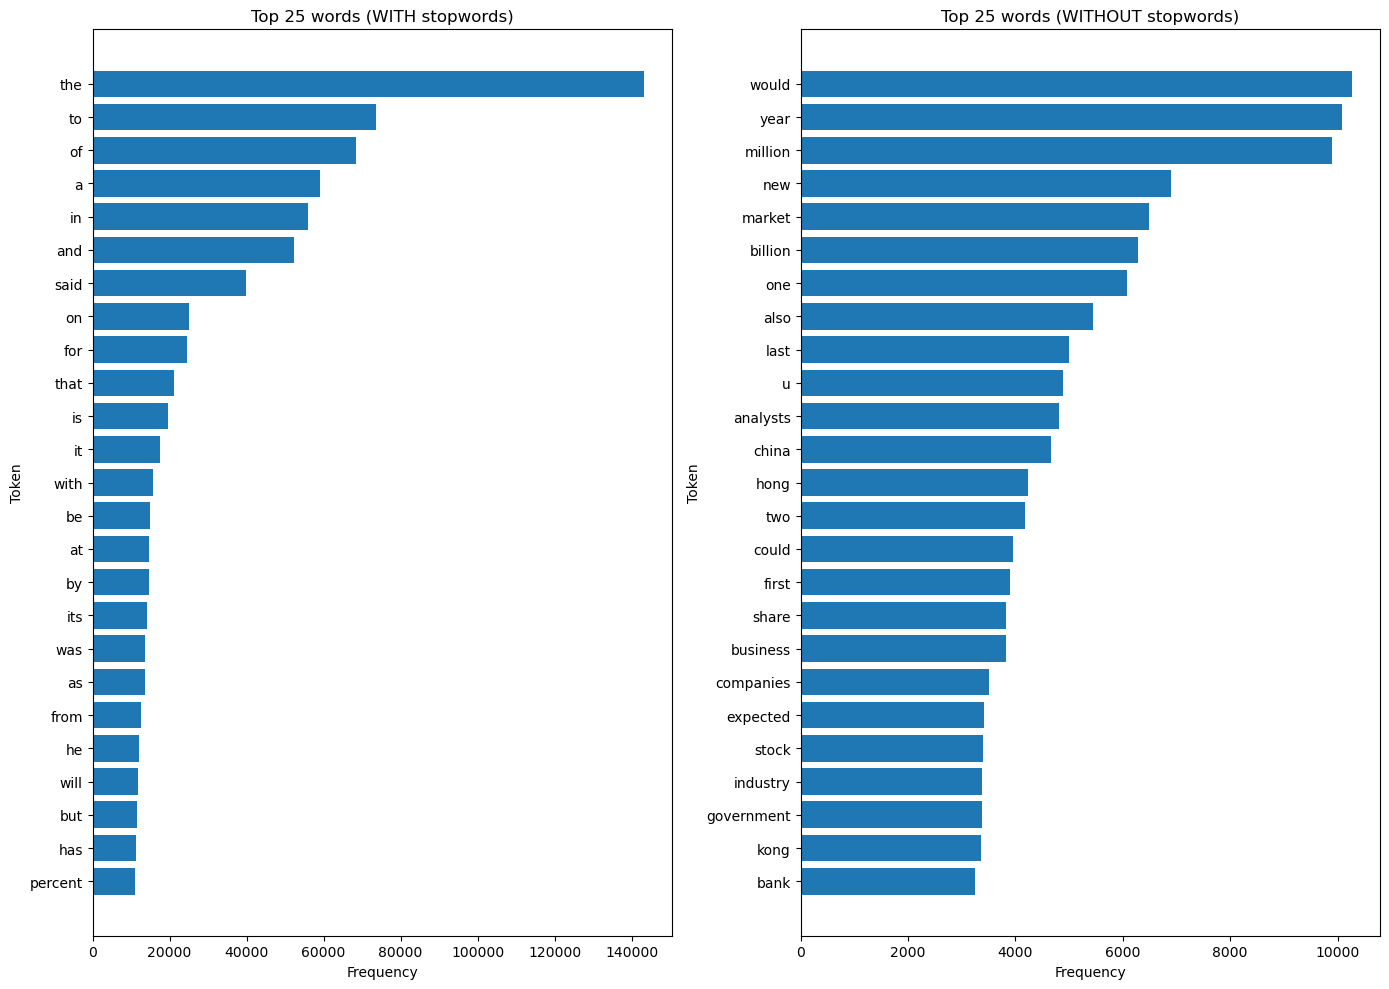

Saved top-25 comparison figure to: eda_outputs/reuters_5050/section2_top25_barcharts.png


In [13]:
# Token-level aggregates
all_tokens = []
for text in df["text"]:
    all_tokens.extend(simple_word_tokenize(text))
# Build full vocab DataFrames (NOT just most_common head)
vocab_all = Counter(all_tokens)
vocab_no_sw = Counter([w for w in all_tokens if w not in STOPWORDS])

df_all = pd.DataFrame(list(vocab_all.items()), columns=["token", "count"]).sort_values("count", ascending=False, ignore_index=True)
df_no_sw = pd.DataFrame(list(vocab_no_sw.items()), columns=["token", "count"]).sort_values("count", ascending=False, ignore_index=True)

# --- TOP 25 ---
topN = 25
top_all_25   = df_all.head(topN).copy()
top_no_sw_25 = df_no_sw.head(topN).copy()

# Plot side-by-side bar charts (top 25)
fig, axes = plt.subplots(1, 2, figsize=(14, 10))

# With stopwords
axes[0].barh(top_all_25["token"].iloc[::-1], top_all_25["count"].iloc[::-1])
axes[0].set_title(f"Top {topN} words (WITH stopwords)")
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Token")

# Without stopwords
axes[1].barh(top_no_sw_25["token"].iloc[::-1], top_no_sw_25["count"].iloc[::-1])
axes[1].set_title(f"Top {topN} words (WITHOUT stopwords)")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Token")

plt.tight_layout()
top_path = SAVE_DIR / "section2_top25_barcharts.png"
plt.savefig(top_path, dpi=200)
plt.show()
print(f"Saved top-25 comparison figure to: {top_path.as_posix()}")


In [19]:
# Let's look at words that only occur once in the entire corpus.
# hapax legomena is anindustry term from latin, meaning "spoken once".
vocab = Counter(all_tokens)
import pandas as pd

# --- Inputs assumed available: `vocab` (Counter of token -> count) ---
# If needed, rebuild:
# from collections import Counter
# all_tokens = []
# for text in df["text"]:
#     all_tokens.extend(simple_word_tokenize(text))
# vocab = Counter(all_tokens)

# Collect hapax words (frequency == 1)
hapax = [w for w, c in vocab.items() if c == 1 and w and w[0].isalpha()]

# Group hapax by starting letter (lowercased)
hapax_by_letter = {ch: [] for ch in string.ascii_lowercase}
for w in hapax:
    hapax_by_letter[w[0].lower()].append(w)

# Config: deterministic alphabetical selection vs random sample
RANDOM_SAMPLE = False   # set True to randomize the 5 picks per letter
if RANDOM_SAMPLE:
    random.seed(42)

# Build rows: each row is exactly 5 words (padded with "")
rows = {}
for ch in string.ascii_lowercase:
    words = hapax_by_letter.get(ch, [])
    if RANDOM_SAMPLE and words:
        picks = random.sample(words, min(5, len(words)))
    else:
        picks = sorted(words)[:5]  # deterministic: first 5 alphabetically
    # pad to 5
    picks += [""] * (5 - len(picks))
    rows[ch.upper()] = picks

# Create DataFrame with letter as the index (no extra numeric columns)
hapax_table = pd.DataFrame.from_dict(rows, orient="index", columns=["Word1","Word2","Word3","Word4","Word5"])
hapax_table.index.name = "Letter"

display(hapax_table)

# Save to CSV with the letter index preserved
hapax_csv_path = SAVE_DIR / "section2_hapax_alphabet_table.csv"
hapax_table.to_csv(hapax_csv_path)  # index is 'Letter'
print(f"Saved hapax alphabet table to: {hapax_csv_path.as_posix()}")

,Word1,Word2,Word3,Word4,Word5
Letter,,,,,
A,a's,aaeu,aah,aan,abadoning
B,baa'c,babayevsky,babcock,babelsberg,babushkas
C,c's,cabbage,cabbages,cabin,cable's
D,d'affairs,d'elite,d'epargne,d'eurotunnel,d'expansion
E,eacho,eagleson,ealier,ealing,earinings
F,fa,fabrications,fabrizio,fabs,fabulously
G,g'beli,gabe,gables,gadre,gaetan
H,haaland,habitation,hachijuni,hackett,hactls
I,i'ts,iacocca,iacocca's,iafrica,iata's


Saved hapax alphabet table to: eda_outputs/reuters_5050/section2_hapax_alphabet_table.csv


## Findings for unique tokens / vocabulary size
There are a few characteristics I'm wary about:
- **Financial** terms appear to dominate the vocabulary
- The "Hapax" (**words appearing only ince in corpus**) indicate some type-o's, grammatical issues, and quirky words. I think we probably don't want to use type-o's as part of the signal we're trying to differentiate, as modern spell- and grammar-checking software should eliminate this issue from electronically-generated text.  
- If we proceed with this corpus, we may want to consider adding **more stopwords** in order to reduce noise presented by jargon.

### Zipf’s Law — What this plot tells us and why it matters

**DESCRIPTION:**  
For each unique token in the corpus, we compute its **frequency** and sort tokens by frequency rank.  Rank is just the position in the sorted list (e.g. the most frequent word has a rank of 1, second-most has a rank of 2, etc). On log–log axes, natural language typically follows a **power law**. A straight line on the plot indicates this power-law behavior. "Alpha" is the estimated exponent.

**NOTES:**  
- **Human language prior:** Human-written corpora usually exhibit a Zipfian heavy tail with "Alpha" approximately -1. This is a strong, well-replicated signature of natural text production.  
- A near-linear trend on log–log axes suggests healthy Zipf behavior (human-like).  

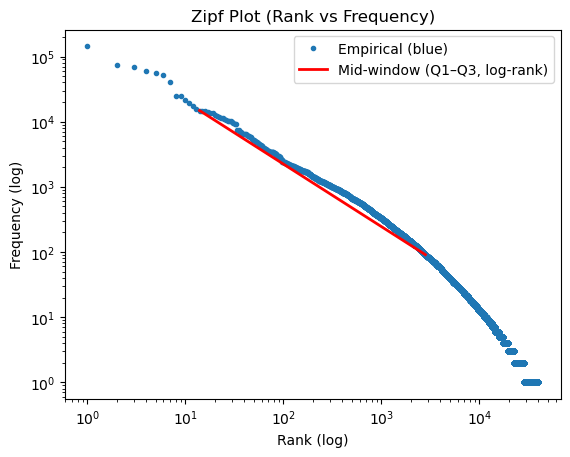

In [24]:

# Zipf plot

# Full vocabulary (with stopwords)
vocab = Counter(all_tokens)
freqs = np.array(sorted(vocab.values(), reverse=True), dtype=float)
ranks = np.arange(1, len(freqs) + 1, dtype=float)

# Plot middle 50% window with geometric quartiles
#   This shows us what the "optimal" power-law fit would look like
N = len(freqs)
r1 = N ** 0.25     # 1st quartile in log space
r3 = N ** 0.75     # 3rd quartile in log space
i1 = int(round(r1 - 1))
i3 = int(round(r3 - 1))
x1, y1 = ranks[i1], freqs[i1]
x3, y3 = ranks[i3], freqs[i3]

plt.figure()
plt.loglog(ranks, freqs, marker='.', linestyle='none', label="Empirical (blue)")
plt.loglog([x1, x3], [y1, y3], 'r-', linewidth=2, label="Mid-window (Q1–Q3, log-rank)")  # mid-50% guide in log space

plt.title("Zipf Plot (Rank vs Frequency)")
plt.xlabel("Rank (log)")
plt.ylabel("Frequency (log)")
plt.legend()

zipf_path = SAVE_DIR / "section2_zipf_plots.png"
plt.savefig(zipf_path, dpi=200)
plt.show()

## Findings for Zipf's Law
- Qualitatively, the slope appears to be fairly flat, which indicates that .
- If we want to quantitatively compare this chart to another dataset, we'd want to fit a line to determine the alpha variable (estimated exponent).

**NOTES:**  
- A **mid-rank window** is generally used for slope analysis to avoid instability at the extremes (very common and very rare words).  
- Domain-specific corpora (**hint, hint,** financial news) may nudge the slope slightly due to jargon or templating. Ensuring the LLM is generating similar corpora should result in similar slopes.


## 3) Stylometric Features

We examine:
- Stopword ratio per document
- Sentence length statistics
- Punctuation frequencies (per 1,000 tokens)
- (Optional) POS tag distributions if spaCy is installed (`en_core_web_sm`)

> Note: POS tagging will be skipped if spaCy or the model is unavailable.


In [25]:

# Stopword ratio & sentence length stats per document
def doc_stylometry(text: str):
    tokens = simple_word_tokenize(text)
    n_tokens = len(tokens)
    sw_count = sum(1 for t in tokens if t in STOPWORDS)
    sw_ratio = sw_count / n_tokens if n_tokens else 0.0

    sents = simple_sent_tokenize(text)
    sent_lens = [len(simple_word_tokenize(s)) for s in sents] or [0]
    sent_mean = float(np.mean(sent_lens))
    sent_std = float(np.std(sent_lens))

    # punctuation counts per 1000 tokens
    punct_counts = Counter(ch for ch in text if ch in ",.;:!?—-()[]\"'")
    per_1000 = {f"punct_{k}": (v / n_tokens * 1000.0 if n_tokens else 0.0) for k, v in punct_counts.items()}

    return {"stopword_ratio": sw_ratio, "sent_len_mean": sent_mean, "sent_len_std": sent_std, **per_1000}

stylomat = df["text"].apply(doc_stylometry).apply(pd.Series)
df_stylo = pd.concat([df[["author","path","n_words","n_sents"]], stylomat], axis=1)
df_stylo.head()


,author,path,n_words,n_sents,stopword_ratio,sent_len_mean,sent_len_std,punct_-,punct_.,"punct_,",punct_:,"punct_""",punct_',punct_?,punct_(,punct_),punct_;,punct_!
0,AaronPressman,data/rcv1-uc-irvine-subset/reuter5050/C50train...,321,14,0.426791,22.928571,11.990855,12.461059,52.959502,74.766355,3.115265,12.461059,6.230530,NaN,NaN,NaN,NaN,NaN
1,AaronPressman,data/rcv1-uc-irvine-subset/reuter5050/C50train...,419,21,0.408115,19.952381,7.961073,16.706444,52.505967,45.346062,NaN,23.866348,4.773270,NaN,NaN,NaN,NaN,NaN
2,AaronPressman,data/rcv1-uc-irvine-subset/reuter5050/C50train...,72,2,0.361111,36.000000,6.000000,13.888889,27.777778,55.555556,NaN,27.777778,NaN,NaN,NaN,NaN,NaN,NaN
3,AaronPressman,data/rcv1-uc-irvine-subset/reuter5050/C50train...,470,20,0.440426,23.500000,5.928744,12.765957,46.808511,55.319149,NaN,27.659574,6.382979,NaN,NaN,NaN,NaN,NaN
4,AaronPressman,data/rcv1-uc-irvine-subset/reuter5050/C50train...,361,14,0.434903,25.785714,7.532582,11.080332,47.091413,58.171745,NaN,30.470914,5.540166,NaN,NaN,NaN,NaN,NaN


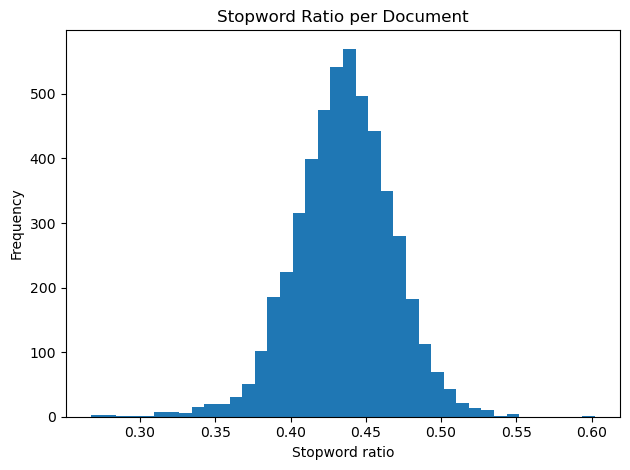

Saved: eda_outputs/reuters_5050/section3_stopword_ratio_hist.png


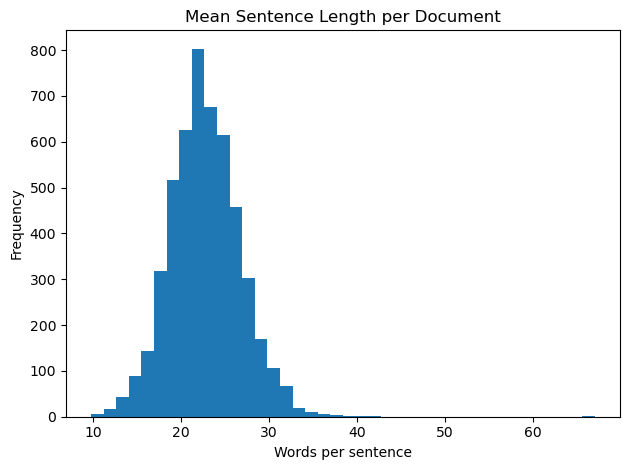

Saved: eda_outputs/reuters_5050/section3_sent_len_mean_hist.png


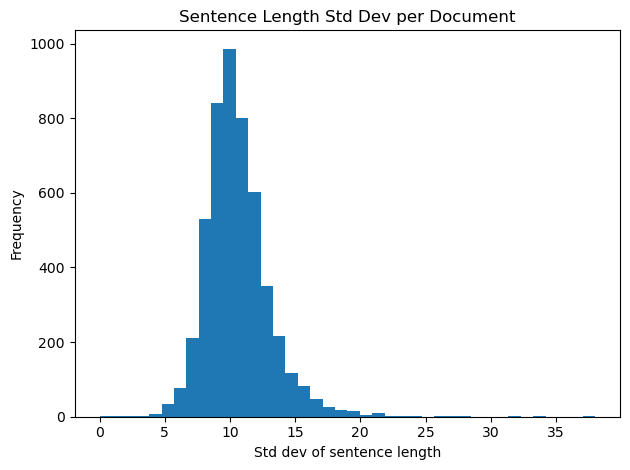

Saved: eda_outputs/reuters_5050/section3_sent_len_std_hist.png


In [26]:
# Visualizations: stopword ratio and sentence length

# 1) Stopword ratio
plt.figure()
plt.hist(df_stylo["stopword_ratio"].dropna(), bins=40)
plt.title("Stopword Ratio per Document")
plt.xlabel("Stopword ratio"); plt.ylabel("Frequency")
plt.tight_layout()
out1 = SAVE_DIR / "section3_stopword_ratio_hist.png"
plt.savefig(out1, dpi=200)
plt.show()
print(f"Saved: {out1.as_posix()}")

# 2) Mean sentence length
plt.figure()
plt.hist(df_stylo["sent_len_mean"].dropna(), bins=40)
plt.title("Mean Sentence Length per Document")
plt.xlabel("Words per sentence"); plt.ylabel("Frequency")
plt.tight_layout()
out2 = SAVE_DIR / "section3_sent_len_mean_hist.png"
plt.savefig(out2, dpi=200)
plt.show()
print(f"Saved: {out2.as_posix()}")

# 3) Sentence length standard deviation
plt.figure()
plt.hist(df_stylo["sent_len_std"].dropna(), bins=40)
plt.title("Sentence Length Std Dev per Document")
plt.xlabel("Std dev of sentence length"); plt.ylabel("Frequency")
plt.tight_layout()
out3 = SAVE_DIR / "section3_sent_len_std_hist.png"
plt.savefig(out3, dpi=200)
plt.show()
print(f"Saved: {out3.as_posix()}")

In [ ]:

# Optional: POS distribution with spaCy if available
pos_df = None
try:
    import spacy
    try:
        nlp = spacy.load("en_core_web_sm")
    except Exception:
        nlp = None
        print("spaCy model 'en_core_web_sm' not available; POS analysis skipped.")
    if nlp is not None:
        pos_counts = []
        for text in df["text"].tolist():
            doc = nlp(text)
            cnt = Counter([t.pos_ for t in doc if t.is_alpha])
            pos_counts.append(cnt)
        # Aggregate
        total_pos = Counter()
        for c in pos_counts:
            total_pos.update(c)
        pos_df = pd.DataFrame(total_pos.items(), columns=["POS","count"]).sort_values("count", ascending=False)
        display(pos_df)

        plt.figure()
        plt.bar(pos_df["POS"], pos_df["count"])
        plt.title("Overall POS Distribution (if spaCy available)")
        plt.xlabel("POS"); plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()
except Exception as e:
    print("spaCy not installed or error during POS tagging:", e)
    pos_df = None


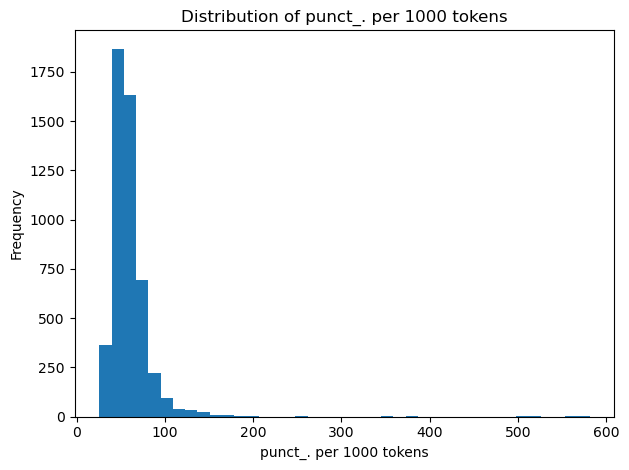

Saved: eda_outputs/reuters_5050/section3_punct_._hist.png


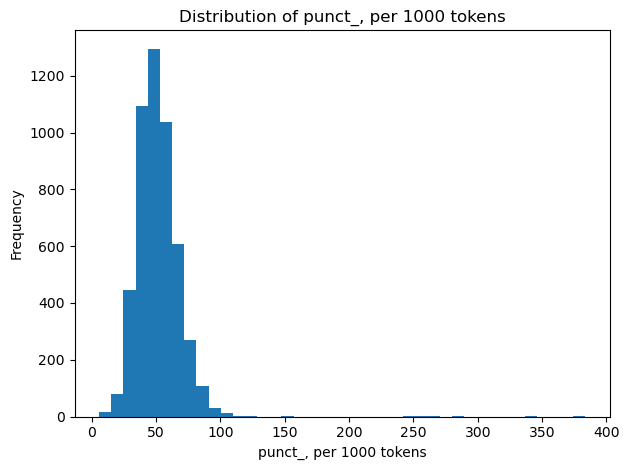

Saved: eda_outputs/reuters_5050/section3_punct_,_hist.png


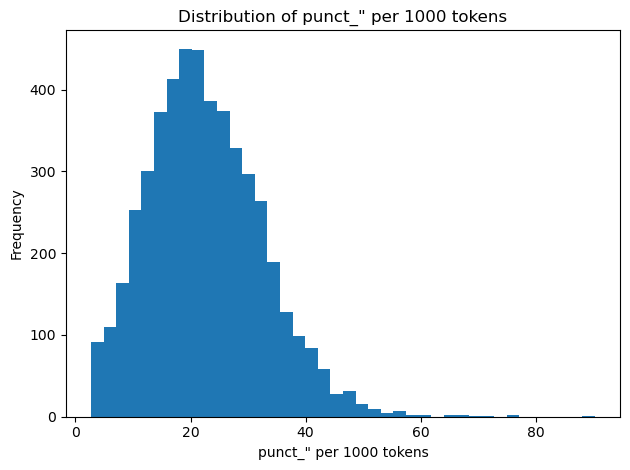

Saved: eda_outputs/reuters_5050/section3_punct_"_hist.png


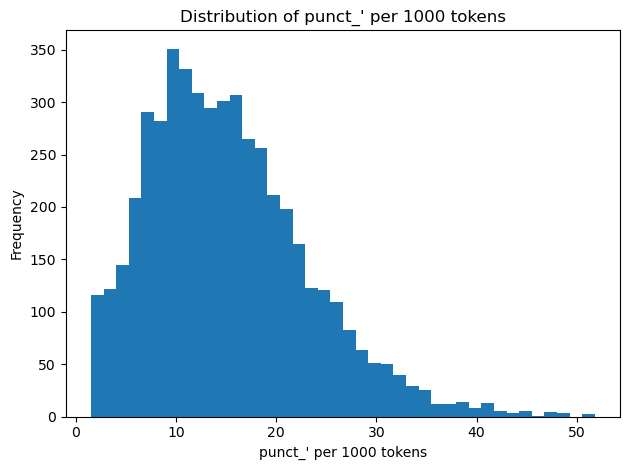

Saved: eda_outputs/reuters_5050/section3_punct_'_hist.png


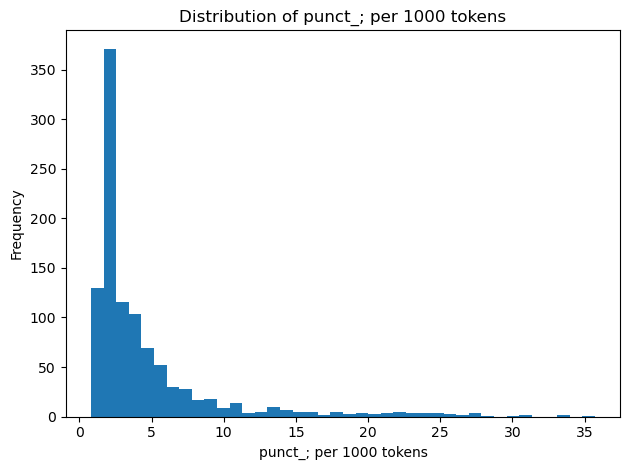

Saved: eda_outputs/reuters_5050/section3_punct_;_hist.png


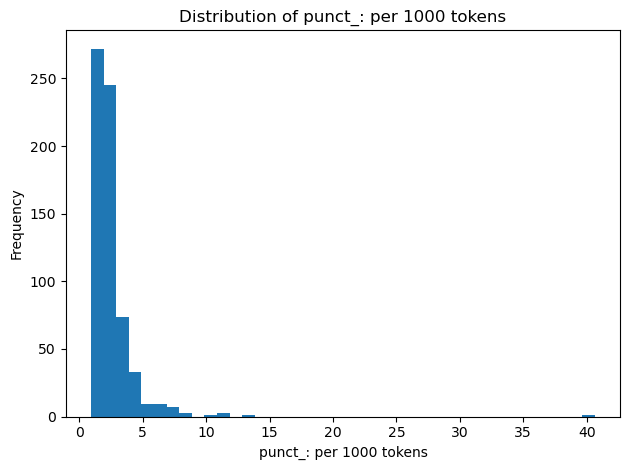

Saved: eda_outputs/reuters_5050/section3_punct_:_hist.png


In [27]:
# Pick some punctuation columns to visualize
punct_cols = ["punct_.", "punct_,", "punct_\"", "punct_'", "punct_;", "punct_:"]

for col in punct_cols:
    if col in df_stylo.columns:
        plt.figure()
        plt.hist(df_stylo[col].dropna(), bins=40)
        plt.title(f"Distribution of {col} per 1000 tokens")
        plt.xlabel(f"{col} per 1000 tokens")
        plt.ylabel("Frequency")
        plt.tight_layout()
        out_path = SAVE_DIR / f"section3_{col}_hist.png"
        plt.savefig(out_path, dpi=200)
        plt.show()
        print(f"Saved: {out_path.as_posix()}")

## Findings for Stylometric Features

Our analysis of stopword ratios, sentence length properties, and punctuation profiles highlights several consistent patterns in the Reuters\_50\_50 corpus:

#### Stopword Ratio
- Distribution centers around **0.40–0.45**, meaning ~40–45% of all tokens are stopwords. 
- This matches expected norms for natural English prose, which is estimated to be 40%-50% (https://www.socratica.com/pages/stop-words#:~:text=overall%20text%20structure:-,English,Russian).
- The distribution appears to be fairly tight across documents, probably indicating a **stable editorial style** in Reuters journalism.  
- For later LLM comparison, this could provide a human baseline. Models may over- or under-produce stopwords, or smooth ratios too much.

#### Mean Sentence Length
- Most documents average **20–25 words per sentence**, with tails extending from ~10 up to ~35+.  
- If the LLM exhibits **too much uniformity** or **too much spread** in sentence lengths, this could be a candidate feature for detection.

#### Sentence Length Variability
- Standard deviation of sentence lengths per document clusters around **8–12 words**, with a tail reaching ~20+.  
- This indicates the presence of some fairly short and long sentences, sometimes referred to as **burstiness**.  
- "Burstiness" might be a candidate signal that can be analyzed for our feature space.

#### Punctuation Usage
All of the plots have an interesting long right tail of higher frequency, but this is especially pronounced in commas and periods.

- **Periods (`.`):** Cluster around 50–80, consistent with sentence lengths of ~20–25 words and reflecting consistent sentence segmentation.  
- **Commas (`,`):** More variable (30–75), reflecting differences in author style and clause chaining.  
- **Semicolons (`;`) and Colons (`:`):** Rare (<5), indicating they are used quite sparingly in Reuters journalism.  
- **Apostrophes (`'`):** Typically 10–20, capturing contractions and possessives, with higher rates in conversational or quoted material.  
- **Quotation Marks (`"`):** Centered around 15–25, but somewhat variable, likely depending on whether the article relies on direct quotes.  

**Implications:** Some of the oft-quoted signatures of LLM punctuation:
- Overuse of **Em dashes** (--).
- "Perfect application" of **semicolons and colons**.
- Consistent use of the "Oxford comma".
Punctuation might yield some potential signals for analysis.


## 4) Burstiness & Repetition

We compute within-document repetition and a burstiness proxy:
- **Repetition:** fraction of tokens that appear ≥2 times within a document; n-gram (1-gram and 2-gram) repetition rate
- **Burstiness:** variance-to-mean ratio (VMR) for top frequent words across documents


In [28]:

def repetition_metrics(text: str):
    toks = simple_word_tokenize(text)
    n = len(toks)
    if n == 0: 
        return {"rep_unigram_frac": 0.0, "rep_bigram_frac": 0.0}
    uni = Counter(toks)
    rep_uni = sum(c for c in uni.values() if c >= 2)
    rep_uni_frac = rep_uni / n

    bigrams = Counter(zip(toks[:-1], toks[1:], strict=False))
    rep_bi = sum(c for c in bigrams.values() if c >= 2)
    rep_bi_frac = rep_bi / max(1, n-1)

    return {"rep_unigram_frac": rep_uni_frac, "rep_bigram_frac": rep_bi_frac}

rep_df = df["text"].apply(repetition_metrics).apply(pd.Series)
df_rep = pd.concat([df[["author","path"]], rep_df], axis=1)
df_rep.head()


,author,path,rep_unigram_frac,rep_bigram_frac
0,AaronPressman,data/rcv1-uc-irvine-subset/reuter5050/C50train...,0.545171,0.128125
1,AaronPressman,data/rcv1-uc-irvine-subset/reuter5050/C50train...,0.584726,0.143541
2,AaronPressman,data/rcv1-uc-irvine-subset/reuter5050/C50train...,0.333333,0.028169
3,AaronPressman,data/rcv1-uc-irvine-subset/reuter5050/C50train...,0.602128,0.142857
4,AaronPressman,data/rcv1-uc-irvine-subset/reuter5050/C50train...,0.606648,0.166667


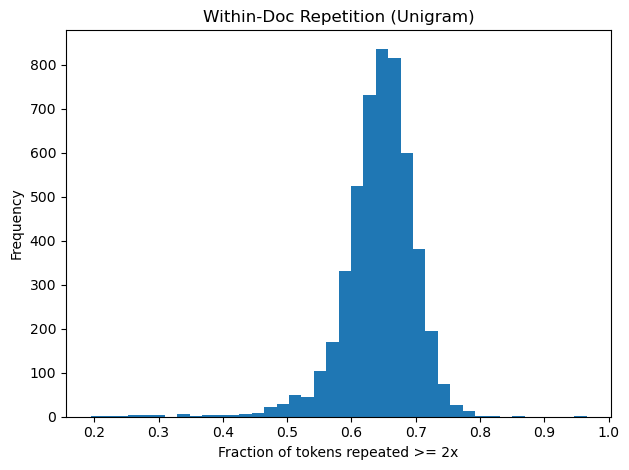

Saved: eda_outputs/reuters_5050/section4_repetition_unigram_hist.png


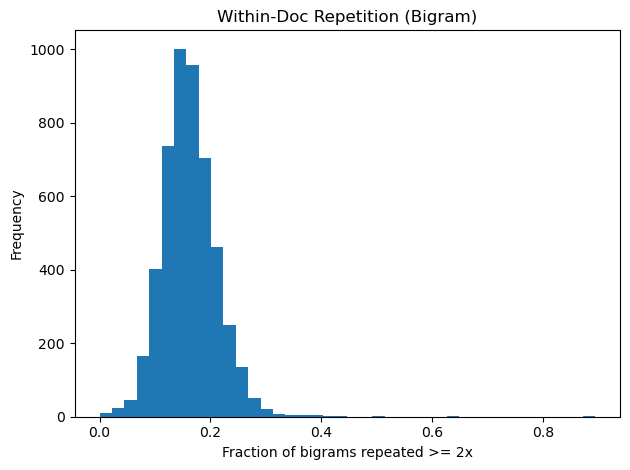

Saved: eda_outputs/reuters_5050/section4_repetition_bigram_hist.png


In [29]:
# Section 4: Repetition histograms + save

# 1) Unigram repetition
plt.figure()
plt.hist(df_rep["rep_unigram_frac"].dropna(), bins=40)
plt.title("Within-Doc Repetition (Unigram)")
plt.xlabel("Fraction of tokens repeated >= 2x"); plt.ylabel("Frequency")
plt.tight_layout()
out_uni = SAVE_DIR / "section4_repetition_unigram_hist.png"
plt.savefig(out_uni, dpi=200)
plt.show()
print(f"Saved: {out_uni.as_posix()}")

# 2) Bigram repetition
plt.figure()
plt.hist(df_rep["rep_bigram_frac"].dropna(), bins=40)
plt.title("Within-Doc Repetition (Bigram)")
plt.xlabel("Fraction of bigrams repeated >= 2x"); plt.ylabel("Frequency")
plt.tight_layout()
out_bi = SAVE_DIR / "section4_repetition_bigram_hist.png"
plt.savefig(out_bi, dpi=200)
plt.show()
print(f"Saved: {out_bi.as_posix()}")


In [30]:

# Burstiness across documents: VMR for top K words
K = 200
top_words = [w for w,_ in Counter(all_tokens).most_common(K)]
counts_per_doc = []
for text in df["text"]:
    toks = simple_word_tokenize(text)
    c = Counter(toks)
    counts_per_doc.append([c[w] for w in top_words])

mat = np.array(counts_per_doc, dtype=float)  # shape: (docs, K)
means = mat.mean(axis=0) + 1e-9
vars_ = mat.var(axis=0)
vmr = vars_ / means

burst_df = pd.DataFrame({"word": top_words, "vmr": vmr, "mean": means})
burst_df_sorted = burst_df.sort_values("vmr", ascending=False).head(30)
burst_df_sorted


,word,vmr,mean
59,hong,9.886493,0.8486
181,internet,7.798434,0.3184
79,kong,7.657165,0.6726
193,tonnes,7.216967,0.2962
147,banks,7.019707,0.3708
81,bank,6.298186,0.6508
90,quarter,6.221093,0.5762
83,sales,6.159787,0.6394
100,amp,5.975757,0.4738
54,china,5.711471,0.9318


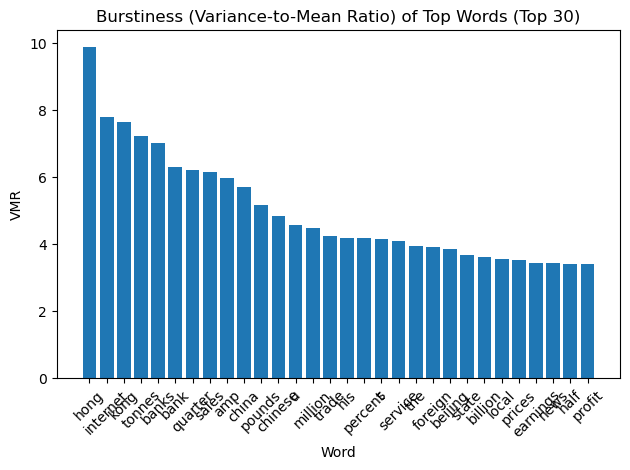

Saved: eda_outputs/reuters_5050/section4_burstiness_top30_vmr.png


In [31]:
plt.figure()
plt.bar(burst_df_sorted["word"], burst_df_sorted["vmr"])
plt.title("Burstiness (Variance-to-Mean Ratio) of Top Words (Top 30)")
plt.xlabel("Word"); plt.ylabel("VMR")
plt.xticks(rotation=45)
plt.tight_layout()
out_burst = SAVE_DIR / "section4_burstiness_top30_vmr.png"
plt.savefig(out_burst, dpi=200)
plt.show()
print(f"Saved: {out_burst.as_posix()}")

### Section 4: Repetition and Burstiness Findings with stopwords

#### Within-Document Repetition
- **Unigram repetition:** Most documents have **60–70% of tokens repeated at least twice**. This indicates heavy use of key entities (*company, market, percent, bank*) and stopwords.  
- **Bigram repetition:** Most documents show **10–20% of bigrams repeated at least twice**. This suggests a moderate level of phrase reuse—common collocations (e.g., *New York*, *per cent*, *Hong Kong*) occur often..  

#### Burstiness of Top Words
- The variance-to-mean ratio (VMR) reveals **highly bursty words** such as *hong*, *interbank*, *tonnes*, and *banks* (VMR ≈ 6–10).  
- Burstiness occurs when words are clustered in some documents but absent in many others—characteristic of topic-driven reporting.  
- Lower VMR terms (≈3–4) such as *profit*, *half*, and *prices* are more evenly distributed across the corpus.  

- **Implication:** Bursty distributions are another characteristic that makes me question whether this is an appropriate corpus for the fingerprinting LLM task.

## Burstiness and Repetition WITHOUT STOPWORDS
Let's take a look at some of those same plots without using the stopwords we've defined at the top of this notebook.

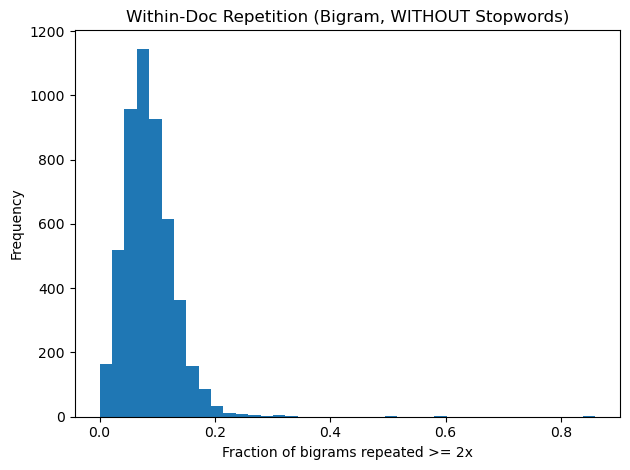

Saved: eda_outputs/reuters_5050/section4_repetition_bigram_without_stopwords_hist.png


In [32]:
# --- Bigram repetition (EXCLUDES stopwords) ---

from collections import Counter

import matplotlib.pyplot as plt
import numpy as np


def bigram_repetition_without_stopwords(text: str, stopwords=None):
    if stopwords is None:
        stopwords = STOPWORDS if "STOPWORDS" in globals() else set()
    toks = [t for t in simple_word_tokenize(text) if t not in stopwords]
    if len(toks) < 2:
        return 0.0
    bigrams = Counter(zip(toks[:-1], toks[1:], strict=False))    # content bigrams only
    rep = sum(c for c in bigrams.values() if c >= 2)
    return rep / (len(toks) - 1)

# Compute per-document metric
rep_bi_no_sw = df["text"].apply(bigram_repetition_without_stopwords)
df_rep = df_rep.copy() if 'df_rep' in globals() else df[["author","path"]].copy()
df_rep["rep_bigram_frac_no_sw"] = rep_bi_no_sw

# Plot + save
plt.figure()
plt.hist(df_rep["rep_bigram_frac_no_sw"].dropna(), bins=40)
plt.title("Within-Doc Repetition (Bigram, WITHOUT Stopwords)")
plt.xlabel("Fraction of bigrams repeated >= 2x")
plt.ylabel("Frequency")
plt.tight_layout()
out_bi_nosw = SAVE_DIR / "section4_repetition_bigram_without_stopwords_hist.png"
plt.savefig(out_bi_nosw, dpi=200)
plt.show()
print(f"Saved: {out_bi_nosw.as_posix()}")

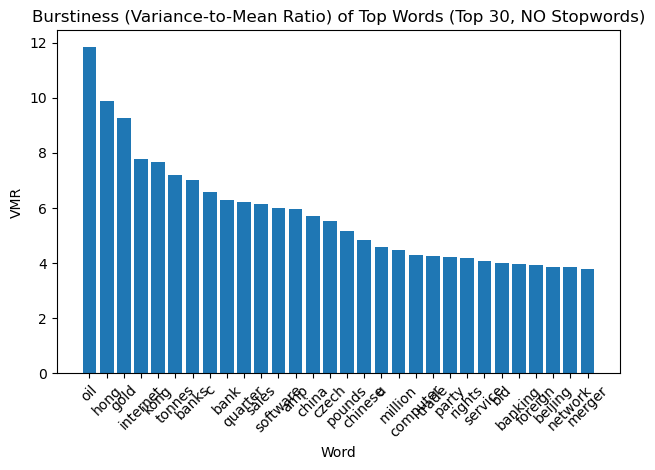

Saved: eda_outputs/reuters_5050/section4_burstiness_top30_no_stopwords_vmr.png


In [34]:
# burstiness (EXCLUDES stopwords)
K = 200  # keep small for speed; adjust if needed

# 1) Tokenize once per doc and filter stopwords
docs_tokens = [
    [t for t in simple_word_tokenize(txt) if t not in STOPWORDS] 
    for txt in df["text"]
]

# 2) Global frequency & pick top-K content words
global_counts = Counter(t for doc in docs_tokens for t in doc)
top_words = [w for w, _ in global_counts.most_common(K)]

# 3) Build counts matrix (docs x K) via per-doc Counters (O(docs * K))
counts_rows = []
for doc in docs_tokens:
    c = Counter(doc)
    counts_rows.append([c.get(w, 0) for w in top_words])

mat = np.asarray(counts_rows, dtype=float)  # shape: (n_docs, K)

# 4) Compute VMR = var/mean per word (avoid divide-by-zero)
means = mat.mean(axis=0)
vars_ = mat.var(axis=0)
vmr = np.divide(vars_, means, out=np.zeros_like(vars_), where=means > 0)

burst_df_no_sw = pd.DataFrame({"word": top_words, "vmr": vmr, "mean": means})
burst_df_no_sw_sorted = burst_df_no_sw.sort_values("vmr", ascending=False).head(30)

# 5) Plot + save
plt.figure()
plt.bar(burst_df_no_sw_sorted["word"], burst_df_no_sw_sorted["vmr"])
plt.title("Burstiness (Variance-to-Mean Ratio) of Top Words (Top 30, NO Stopwords)")
plt.xlabel("Word"); plt.ylabel("VMR")
plt.xticks(rotation=45)
plt.tight_layout()
out_burst_nosw = SAVE_DIR / "section4_burstiness_top30_no_stopwords_vmr.png"
plt.savefig(out_burst_nosw, dpi=200)
plt.show()
print(f"Saved: {out_burst_nosw.as_posix()}")


### Section 4: Comparing With vs Without Stopwords

#### Bigram Repetition
- **With stopwords:** Distribution centered higher (~0.15–0.20). Frequent function-word pairs (*of the, in the, to the*) inflate repetition.  
- **Without stopwords:** Distribution shifts lower (~0.05–0.10). Content bigrams are less repetitive, reflecting more lexical diversity.  
- **Takeaway:** Removing stopwords sharpens the signal to topical phrase reuse rather than structural patterns.

#### Burstiness
There is little difference in the top K frequency words when it comes to VMR.  You'll notice that "Oil" wasn't present in the original "with stopwords" chart; this is because the top K frequency words likely had many stopwords in it.  The reason we chose top K was to simplify the computation.

## 5) Temporal / Sequential Structure (Signal Proxies)

We treat **sentence length** (in words) as a sequence per document, then compute:

- **Autocorrelation:** Measures how similar the sequence is to itself when shifted by a lag. High values indicate repeated rhythm (e.g., clusters of short or long sentences).  
- **Fourier power spectrum:** Decomposes the sequence into frequency components, showing whether certain rhythmic patterns (cycles of long/short sentences) dominate.

These provide a rough, model-free glimpse into structural periodicities that we will later refine with token log-probs and other symbols.

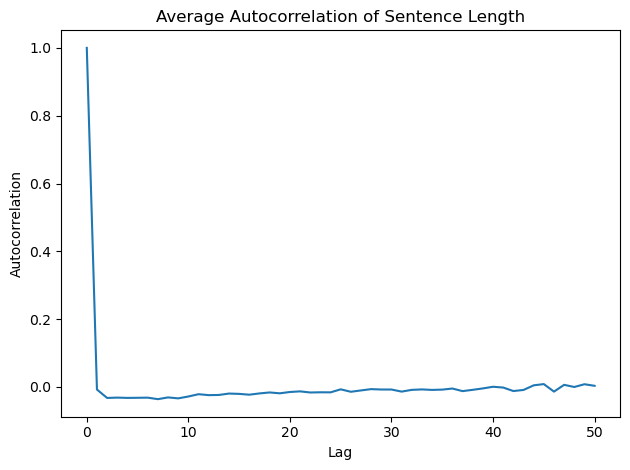

Saved: eda_outputs/reuters_5050/section5_sentlen_autocorrelation.png  |  docs used: 4993


In [37]:
# --- Section 5: Autocorrelation of sentence length ---

import matplotlib.pyplot as plt
import numpy as np


def sent_lengths(text):
    sents = simple_sent_tokenize(text)
    return [len(simple_word_tokenize(s)) for s in sents if s.strip()]

max_lag = 50
acfs = []

for txt in df["text"]:
    sl = sent_lengths(txt)
    if len(sl) < 3:   # very short docs can't provide lags
        continue
    x = np.asarray(sl, dtype=float)
    x = x - x.mean()
    s = x.std()
    if s == 0:
        continue
    x /= s

    c = np.correlate(x, x, mode="full")
    mid = len(c) // 2
    max_avail = len(x) - 1                    # maximum meaningful lag for this doc
    L = min(max_lag, max_avail)

    acf = c[mid:mid+L+1] / c[mid]             # length = L+1, with acf[0] = 1
    # pad to (max_lag+1) so arrays align
    if L < max_lag:
        pad = np.full((max_lag - L,), np.nan)
        acf = np.concatenate([acf, pad])
    acfs.append(acf)

if not acfs:
    raise ValueError("No documents had enough sentences for autocorrelation.")

A = np.vstack(acfs)                            # shape: (n_docs, max_lag+1)
avg_acf = np.nanmean(A, axis=0)                # ignore NaN pads when averaging

plt.figure()
plt.plot(np.arange(len(avg_acf)), avg_acf)
plt.title("Average Autocorrelation of Sentence Length")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
out_acf = SAVE_DIR / "section5_sentlen_autocorrelation.png"
plt.savefig(out_acf, dpi=200)
plt.show()
print(f"Saved: {out_acf.as_posix()}  |  docs used: {A.shape[0]}")

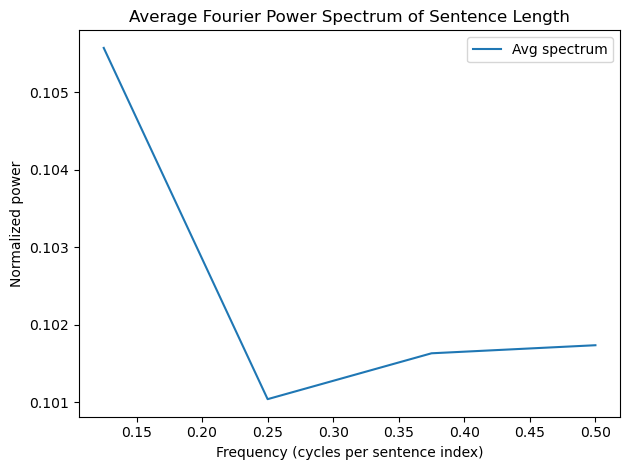

Saved: eda_outputs/reuters_5050/section5_sentlen_fourier_spectrum_simple.png  |  docs used: 4933


In [39]:
# Fourier power spectrum of sentence length (simple + fixed)

def sent_lengths(text):
    sents = simple_sent_tokenize(text)
    return [len(simple_word_tokenize(s)) for s in sents if s.strip()]

all_specs = []
for txt in df["text"]:
    sl = sent_lengths(txt)
    if len(sl) < 8:
        continue
    x = np.array(sl, dtype=float)
    x = x - x.mean()                    # remove DC
    spec = np.abs(np.fft.rfft(x))**2    # power
    ssum = spec.sum()
    if ssum == 0:
        continue
    spec = spec / ssum                  # normalize
    all_specs.append(spec)

if not all_specs:
    raise ValueError("No documents had enough sentences for Fourier analysis.")

# Truncate all spectra to the shortest spectrum length (in freq bins)
Nf = min(len(s) for s in all_specs)
spec_stack = np.vstack([s[:Nf] for s in all_specs])
avg_spec = spec_stack.mean(axis=0)

# Compute frequency axis from inferred time length: N_time = 2*(Nf-1)
N_time = int(2 * (Nf - 1))
freqs = np.fft.rfftfreq(N_time, d=1.0)   # length == Nf

plt.figure()
plt.plot(freqs[1:], avg_spec[1:], label="Avg spectrum")  # drop DC
plt.title("Average Fourier Power Spectrum of Sentence Length")
plt.xlabel("Frequency (cycles per sentence index)")
plt.ylabel("Normalized power")
plt.legend()
plt.tight_layout()
out_fft = SAVE_DIR / "section5_sentlen_fourier_spectrum_simple.png"
plt.savefig(out_fft, dpi=200)
plt.show()
print(f"Saved: {out_fft.as_posix()}  |  docs used: {spec_stack.shape[0]}")

## Section 5: Temporal / Sequential Structure Findings

### Autocorrelation of Sentence Length
- The average autocorrelation drops immediately after lag 1, hovering near zero for all subsequent lags.  
- This indicates that **sentence lengths are not strongly dependent on one another** beyond the immediately adjacent sentence.  

### Fourier Power Spectrum of Sentence Length
- The spectrum is relatively **flat across frequencies**, with no dominant peaks.  
- A flat spectrum suggests **little periodic structure** in sentence length (i.e., people do not alternate short/long sentences in a fixed rhythm).  


## 6) Correlations & Quick Dashboard

We compute a correlation matrix on numeric features and visualize key relationships.


Saved correlations CSV: eda_outputs/reuters_5050/section6_feature_correlations.csv


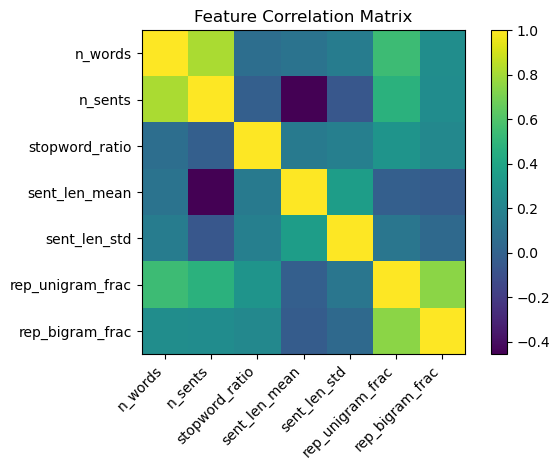

Saved: eda_outputs/reuters_5050/section6_feature_correlation_matrix.png


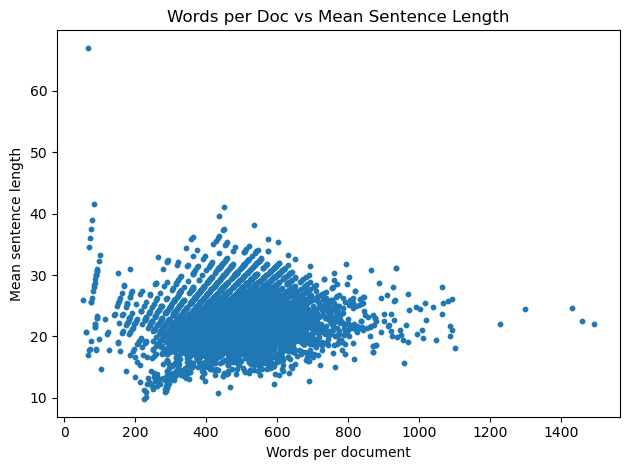

Saved: eda_outputs/reuters_5050/section6_words_vs_sentlen_scatter.png


In [41]:
# Merge key numeric features
features = pd.concat(
    [
        df[["n_words","n_sents"]],
        df_stylo[["stopword_ratio","sent_len_mean","sent_len_std"]],
        df_rep[["rep_unigram_frac","rep_bigram_frac"]],
    ],
    axis=1
)

corr = features.corr(numeric_only=True)
corr_csv = SAVE_DIR / "section6_feature_correlations.csv"
corr.to_csv(corr_csv)
print(f"Saved correlations CSV: {corr_csv.as_posix()}")

# Correlation heatmap
plt.figure()
plt.imshow(corr)  # no specific colormap
plt.title("Feature Correlation Matrix")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.tight_layout()
corr_img = SAVE_DIR / "section6_feature_correlation_matrix.png"
plt.savefig(corr_img, dpi=200)
plt.show()
print(f"Saved: {corr_img.as_posix()}")

# Example scatter: words vs mean sentence length
plt.figure()
plt.scatter(features["n_words"], features["sent_len_mean"], s=10)
plt.title("Words per Doc vs Mean Sentence Length")
plt.xlabel("Words per document"); plt.ylabel("Mean sentence length")
plt.tight_layout()
scatter_img = SAVE_DIR / "section6_words_vs_sentlen_scatter.png"
plt.savefig(scatter_img, dpi=200)
plt.show()
print(f"Saved: {scatter_img.as_posix()}")


## Section 6: Feature Correlation Analysis

### Correlation Matrix
- **Document length features**:  
  - `n_words` and `n_sents` are **highly correlated** (~0.85+), which is expected since longer documents naturally contain more sentences.  
  - `sent_len_mean` shows a **weak negative correlation** with `n_words`/`n_sents`.
- **Stopword ratio**:  
  - Correlates weakly with other features. This indicates that function-word usage (like "the", "and", "of") is relatively stable across documents.
- **Repetition features**:  
  - `rep_unigram_frac` and `rep_bigram_frac` are **strongly correlated** (~0.7+), indicating documents with more repeated words also tend to repeat word pairs.  

### Scatter Plot: Words per Document vs Mean Sentence Length
- The scatter confirms that **longer documents do not necessarily have longer sentences**.  
- Most documents cluster in the range of **200–800 words** with **mean sentence length ~18–28 words**.  
- Outliers exist at very high sentence lengths (>50 words per sentence) or unusually short documents with high variability.